## RNN Time Series Implementation

In [3]:
# Importing the Libraries
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [6]:
# Data from Federal Reserve Economic Database (FRED)[https://fred.stlouisfed.org/]
filename = 'Data/Alcohol_sales.csv'

In [7]:
df = pd.read_csv(filename, index_col = 0, parse_dates = True)

In [10]:
df.head()
# monthly increments

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [15]:
df = df.dropna()

In [14]:
len(df)

325

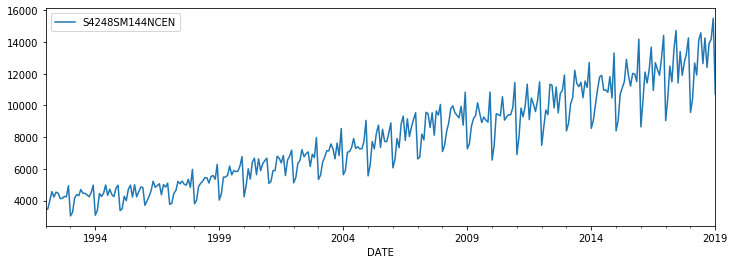

In [17]:
df.plot(figsize = (12, 4))
# clear seasonality 
# general upward trend

In [18]:
y = df['S4248SM144NCEN'].values.astype(float)

In [20]:
# Using 1 year as a test size
test_size = 12

In [22]:
train = y[:-test_size]
test = y[-test_size:]

In [27]:
# Normalisation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train.reshape(-1,1))

In [30]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [46]:
# Hyperparams
seq_size = 12
hidden_dim = 100
lr = 0.001
epochs = 100

In [36]:
# prepare data for LSTM
def prep_data(seq, ss):
    output = []
    l = len(seq)
    
    for i in range(l - ss):
        data = seq[i:i+ss]
        label = seq[i+ss:i+ss+1]
        output.append((data,label))
    
    return output

In [37]:
train_data = prep_data(train_norm, seq_size)

In [38]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

In [43]:
# Model
class LSTM(nn.Module):
    def __init__(self, input_dim = 1, hidden_dim = hidden_dim, output_dim = 1):
        
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        
        self.hidden = (torch.zeros(1,1,hidden_dim), torch.zeros(1,1,hidden_dim))
    
    def forward(self, seq):
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.fc1(lstm_out.view(len(seq), -1))
        
        return pred[-1]

In [44]:
# Initialise 
model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [45]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [49]:
import time
start_time = time.time()

for i in range(epochs):
    for  seq, y_train in train_data:
        
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1,1,model.hidden_dim),torch.zeros(1,1,model.hidden_dim))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # training result
    print(f'Epoch: {i+1:2} | Loss: {loss.item():10.8f}')


total_time = time.time() - start_time
print(f'Total time: {total_time}')

Epoch:  1 | Loss: 0.24553171
Epoch:  2 | Loss: 0.41693893
Epoch:  3 | Loss: 0.35294610
Epoch:  4 | Loss: 0.32442498
Epoch:  5 | Loss: 0.32143822
Epoch:  6 | Loss: 0.32025343
Epoch:  7 | Loss: 0.31507227
Epoch:  8 | Loss: 0.30184722
Epoch:  9 | Loss: 0.27275091
Epoch: 10 | Loss: 0.29818234
Epoch: 11 | Loss: 0.30082694
Epoch: 12 | Loss: 0.27496079
Epoch: 13 | Loss: 0.27634084
Epoch: 14 | Loss: 0.26949033
Epoch: 15 | Loss: 0.26848570
Epoch: 16 | Loss: 0.27460441
Epoch: 17 | Loss: 0.25887915
Epoch: 18 | Loss: 0.25251794
Epoch: 19 | Loss: 0.25885352
Epoch: 20 | Loss: 0.24418823
Epoch: 21 | Loss: 0.22600210
Epoch: 22 | Loss: 0.14334342
Epoch: 23 | Loss: 0.07208514
Epoch: 24 | Loss: 0.00014777
Epoch: 25 | Loss: 0.00293304
Epoch: 26 | Loss: 0.05147839
Epoch: 27 | Loss: 0.01332575
Epoch: 28 | Loss: 0.00779642
Epoch: 29 | Loss: 0.04670882
Epoch: 30 | Loss: 0.01232077
Epoch: 31 | Loss: 0.00143333
Epoch: 32 | Loss: 0.00022482
Epoch: 33 | Loss: 0.00014317
Epoch: 34 | Loss: 0.00182133
Epoch: 35 | Lo

In [51]:
future = 12
preds = train_norm[-seq_size:].tolist()

model.eval()

# test loss against predicitons
preds = train[-seq_size:].tolist()

for f in range(future):  
    seq = torch.FloatTensor(preds[-seq_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_dim),torch.zeros(1,1,model.hidden_dim))
            
        preds.append(model(seq).item())

In [52]:
preds[seq_size:]
# prediction values normalised

[-1.232832908630371,
 0.1572849601507187,
 0.5346875786781311,
 0.38716280460357666,
 0.5764715671539307,
 0.6934604644775391,
 0.3058074712753296,
 0.20087456703186035,
 0.4959036111831665,
 0.46859776973724365,
 0.6093724966049194,
 0.911101758480072]

In [53]:
true_preds = scaler.inverse_transform(np.array(preds[seq_size:]).reshape(-1,1))

In [54]:
true_preds

array([[ 1669.04390097],
       [ 9800.5383744 ],
       [12008.15499148],
       [11145.20882553],
       [12252.57043207],
       [12936.89698696],
       [10669.32080323],
       [10055.51577985],
       [11781.28817362],
       [11621.56265408],
       [12445.02441889],
       [14209.98973623]])

In [55]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [56]:
x = np.arange('2018-02-01','2019-02-01', dtype = 'datetime64[M]')

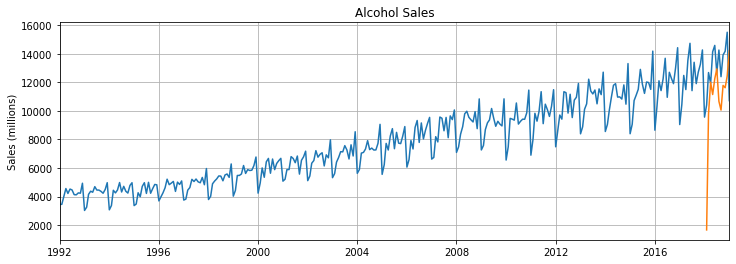

In [58]:
# plot predicitons
plt.figure(figsize=(12, 4))
plt.title('Alcohol Sales')
plt.ylabel('Sales (millions)')
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_preds)
plt.show()

In [59]:
# random seed cause outlier ?